# QASSIS: _Quality Algorithm to Search Stuff In Spectra_



In [612]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig
from lmfit import minimize, Parameters, fit_report, Model, Parameter
import corner as corner
%matplotlib inline

In [613]:
# Get spectrum file
spectrum_file = "181_WSW_FTS200_3mm_average_data_Tmb.dat"
spectrum = np.loadtxt(spectrum_file)

frequencies = spectrum[:,0]
intensities = spectrum[:,1]

# Get molecular catalog file
molecule_name = "CH3CN"
molecule_file = "CH3CN.txt"
molecule_catalog = pd.read_csv(molecule_file, delimiter="\t", header=0, index_col=False)

molecule_frequencies = molecule_catalog["Frequency(Ghz)"]
molecule_intensities = molecule_catalog["Intensity(K)"]
molecule_eup = molecule_catalog["Eup(K)"]
molecule_aij = molecule_catalog["Aij"]
molecule_transition = molecule_catalog["Transition"]

In [614]:
# Find possible emission lines
width = 0.5 

peaks = sig.find_peaks(intensities)[0]
peak_intensities = intensities[peaks]
peak_frequencies = frequencies[peaks]

noise = 3*5e-3
rms = [5*5e-3 for p in peak_frequencies]

emission_line_frequencies = []
emission_line_intensities = []
emission_line_eup = []
emission_line_aij = []
emission_line_transition = []

for i,f1 in enumerate(peak_frequencies):
    for j,f2 in enumerate(molecule_frequencies):
        if abs(f1-f2) < width and peak_intensities[i]>rms[i]:
            emission_line_frequencies.append(f1)
            emission_line_intensities.append(peak_intensities[i])
            emission_line_eup.append(molecule_eup[j])
            emission_line_aij.append(molecule_aij[j])
            emission_line_transition.append(molecule_transition[j])
            
print(emission_line_frequencies)

[73588.7747, 73590.3372, 91985.2624, 91987.0202, 110381.359, 110383.508]


# Fit Gaussians to Emission Lines

## Find best fit by least-squares and then feed that result to an MCMC algorithm because, well, why not? (*emcee*,  Dan Foreman-Mackey 2019)

In [616]:
# Define a window for each line

window_size = 5 # default 5

window_frequencies = []
window_intensities = []

for f in emission_line_frequencies:
    window_f = frequencies[abs(frequencies-f)<window_size]
    window_i = intensities[abs(frequencies-f)<window_size]
    window_frequencies.append(window_f)
    window_intensities.append(window_i)
    
# For each window, define what the BASELINE is

baseline_frequencies = []
baseline_intensities = []

for i,window in enumerate(window_frequencies):
    baseline_window_frequencies = []
    baseline_window_intensities = []
    for j,freq in enumerate(window):
        if window_intensities[i][j] <= abs(noise) and abs(freq-emission_line_frequencies[i]) > 2*width:
            baseline_window_frequencies.append(freq)
            baseline_window_intensities.append(window_intensities[i][j])
    baseline_frequencies.append(baseline_window_frequencies)
    baseline_intensities.append(baseline_window_intensities)
    
# Fit a polynomial to the baseline
degree = 2

baseline_polynomials = []

for i,baseline_window_frequencies in enumerate(baseline_frequencies):
    baseline_fit = np.polyfit(baseline_window_frequencies, baseline_intensities[i], degree)
    baseline = np.poly1d(baseline_fit)
    baseline_polynomials.append(baseline)
    
# Subtract baseline polynomial from window intensities

window_intensities_corrected = []

for i,window in enumerate(window_intensities):
    window_intensities_corrected.append(window_intensities[i]-baseline_polynomials[i](window_frequencies[i]))
    
# For each window, define what the LINE is

line_frequencies = []
line_intensities = []

for i,window in enumerate(window_frequencies):
    line_window_frequencies = []
    line_window_intensities = []
    for j,freq in enumerate(window):
        if abs(freq-emission_line_frequencies[i]) <= 1*width and window_intensities_corrected[i][j]>=0:
            line_window_frequencies.append(freq)
            line_window_intensities.append(window_intensities_corrected[i][j])
    line_frequencies.append(line_window_frequencies)
    line_intensities.append(line_window_intensities)
    
# Fit a Gaussian to the line

gaussian_fits = []

def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

for i,line_f in enumerate(line_frequencies):
    x = line_frequencies[i]
    y = line_intensities[i]
    
    # Do least squares first
    gmodel = Model(gaussian)
    params = gmodel.make_params()
    params["amp"] = Parameter(name='amp', value=0.01)
    params["cen"] = Parameter(name='cen', value=emission_line_frequencies[i])
    params["wid"] = Parameter(name='wid', value=width)
    
    result = gmodel.fit(y, x=x, params=params, method="leastsq")
    
    # Now do MCMC
    
    amp = result.best_values["amp"]
    cen = result.best_values["cen"]
    wid = result.best_values["wid"]
    
    gmodel = Model(gaussian)
    params = gmodel.make_params()
    params["amp"] = Parameter(name='amp', value=amp, min=max(0,amp-3*result.params["amp"].stderr), max=amp+3*result.params["amp"].stderr)
    params["cen"] = Parameter(name='cen', value=cen, min=cen-5*result.params["cen"].stderr, max=cen+5*result.params["cen"].stderr)
    params["wid"] = Parameter(name='wid', value=wid, min=max(0,wid-3*result.params["wid"].stderr), max=wid+3*result.params["wid"].stderr)
    
    result = gmodel.fit(y, x=x, params=params, method="emcee")

    
    
    gaussian_fits.append(result)
    print(result.fit_report())

# Define a linspace in each window for plotting purposes

window_linspaces = []
for i,window in enumerate(window_frequencies):
    window_linspaces.append(np.linspace(min(window), max(window),10000))

  4%|▎         | 37/1000 [00:00<00:05, 182.94it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 3
    # variables        = 3
    chi-square         = 5.0989e-15
    reduced chi-square = 5.0989e-15
    Akaike info crit   = -96.0250814
    Bayesian info crit = -98.7292445
[[Variables]]
    amp:  0.02052007 +/- 2.0231e-06 (0.01%) (init = 0.02052005)
    cen:  73588.7981 +/- 7.19190829 (0.01%) (init = 73588.8)
    wid:  0.17387424 +/- 2.0288e-05 (0.01%) (init = 0.1738741)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.252


  4%|▍         | 38/1000 [00:00<00:05, 186.69it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 5
    # variables        = 3
    chi-square         = 4.8592e-05
    reduced chi-square = 2.4296e-05
    Akaike info crit   = -51.7074591
    Bayesian info crit = -52.8791453
[[Variables]]
    amp:  0.02386326 +/- 0.00180885 (7.58%) (init = 0.02386301)
    cen:  73590.2391 +/- 6.25191313 (0.01%) (init = 73590.25)
    wid:  0.13336144 +/- 0.01403096 (10.52%) (init = 0.1333593)


  4%|▍         | 40/1000 [00:00<00:04, 203.47it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 4
    # variables        = 3
    chi-square         = 1.0303e-05
    reduced chi-square = 1.0303e-05
    Akaike info crit   = -45.4776184
    Bayesian info crit = -47.3187353
[[Variables]]
    amp:  0.01865175 +/- 0.00134274 (7.20%) (init = 0.01865188)
    cen:  91985.3299 +/- 7.12485953 (0.01%) (init = 91985.33)
    wid:  0.13359986 +/- 0.01277042 (9.56%) (init = 0.1336039)


  4%|▎         | 35/1000 [00:00<00:05, 177.53it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 4
    # variables        = 3
    chi-square         = 2.9634e-05
    reduced chi-square = 2.9634e-05
    Akaike info crit   = -41.2514959
    Bayesian info crit = -43.0926129
[[Variables]]
    amp:  0.02207735 +/- 6.8138e-04 (3.09%) (init = 0.02207774)
    cen:  91987.1152 +/- 8.12393186 (0.01%) (init = 91987.11)
    wid:  0.12634220 +/- 0.00623564 (4.94%) (init = 0.1263394)


  2%|▏         | 17/1000 [00:00<00:05, 165.13it/s]

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 5
    # variables        = 3
    chi-square         = 2.5870e-05
    reduced chi-square = 1.2935e-05
    Akaike info crit   = -54.8592761
    Bayesian info crit = -56.0309624
[[Variables]]
    amp:  0.01157532 +/- 0.00184080 (15.90%) (init = 0.01157525)
    cen:  110381.362 +/- 3.94742537 (0.00%) (init = 110381.4)
    wid:  0.16476591 +/- 0.02955008 (17.93%) (init = 0.1647617)


100%|██████████| 1000/1000 [00:07<00:00, 130.85it/s]


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 5
    # variables        = 3
    chi-square         = 1.1264e-06
    reduced chi-square = 5.6321e-07
    Akaike info crit   = -70.5295614
    Bayesian info crit = -71.7012477
[[Variables]]
    amp:  0.01027308 +/- 2.0688e-06 (0.02%) (init = 0.01027303)
    cen:  110383.563 +/- 8.60311357 (0.01%) (init = 110383.6)
    wid:  0.10745587 +/- 2.1835e-05 (0.02%) (init = 0.1074548)


## Check best fits

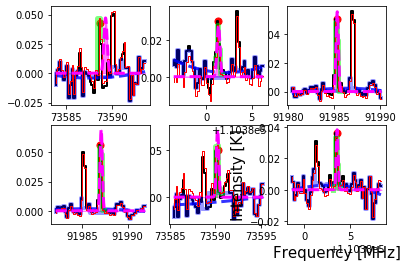

In [617]:
for i,line in enumerate(window_intensities):

    plt.subplot2grid((2,3),(i%2,i%3))
    plt.step(window_frequencies[i], window_intensities[i], linewidth=2, c="black")
    plt.step(baseline_frequencies[i], baseline_intensities[i], linewidth=4, c="blue", alpha=0.4)
    plt.scatter(emission_line_frequencies[i], emission_line_intensities[i], s=50, c="red")

    F_linspace = np.linspace(min(window_frequencies[i]), max(window_frequencies[i]),100)
    plt.plot(F_linspace, baseline_polynomials[i](F_linspace), color="blue", linestyle="--", linewidth=3, alpha=0.8)


    plt.step(line_frequencies[i], line_intensities[i], linewidth=5, c="lime", alpha=0.5)

    plt.step(window_frequencies[i], window_intensities_corrected[i], c="red", linewidth=1)

    amp = np.median(gaussian_fits[i].flatchain["amp"])
    cen = np.median(gaussian_fits[i].flatchain["cen"])
    wid = np.median(gaussian_fits[i].flatchain["wid"])
    
    #amp = gaussian_fits[i].best_values["amp"]
    #cen = gaussian_fits[i].best_values["cen"]
    #wid = gaussian_fits[i].best_values["wid"]
    
    gauss = gaussian(window_linspaces[i], amp, cen, wid)
    plt.plot(window_linspaces[i], gauss, linestyle='--', color="magenta", label='best fit', linewidth=3)

    plt.fill_between(window_linspaces[i], y1=[0 for x in window_linspaces[i]], y2 =gauss , color="magenta", alpha=0.5)

plt.xlabel("Frequency [MHz]", fontsize=15)
plt.ylabel("Intensity [K]", fontsize=15)

plt.show()

## Correlation plots to double check _emcee_ didn't go insane

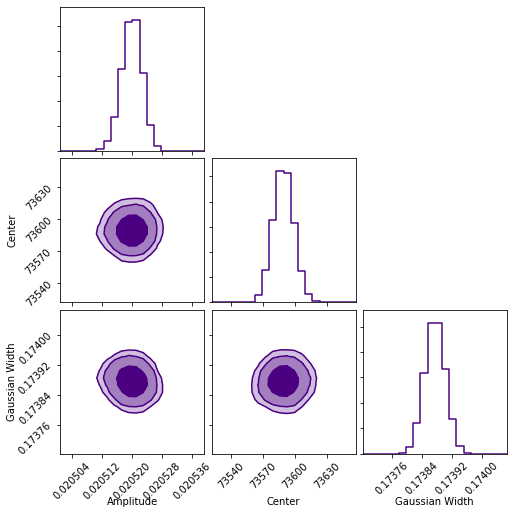

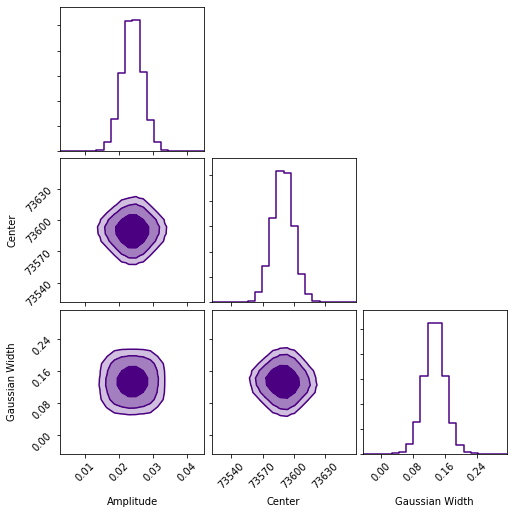

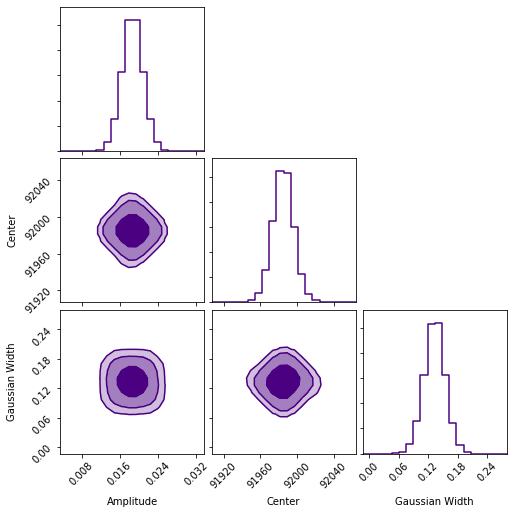

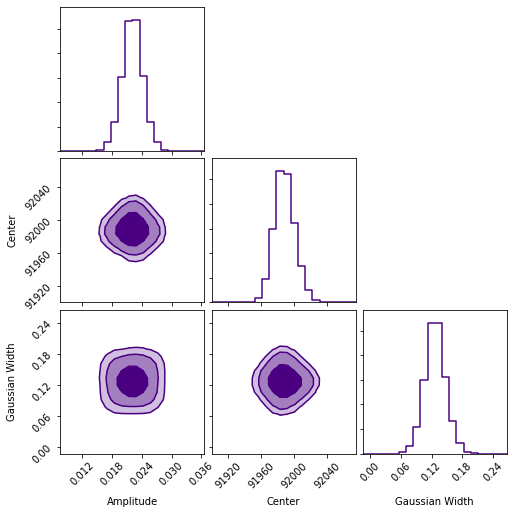

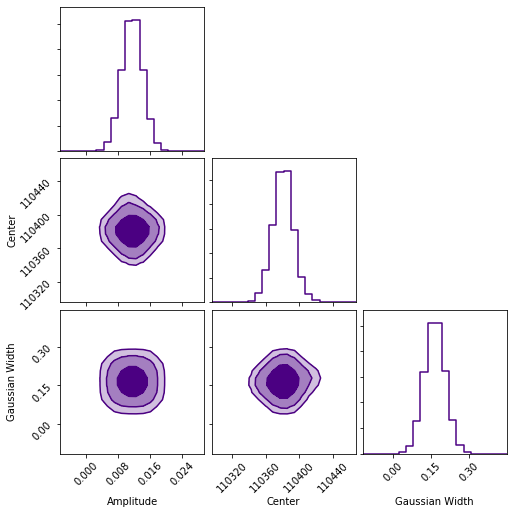

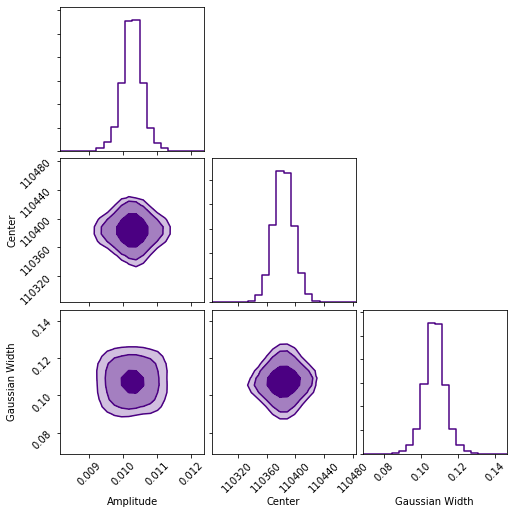

In [618]:
for i,line in enumerate(window_intensities):
    amp = np.median(gaussian_fits[i].flatchain["amp"])
    cen = np.median(gaussian_fits[i].flatchain["cen"])
    wid = np.median(gaussian_fits[i].flatchain["wid"])
    
    amp_err = np.std(gaussian_fits[i].flatchain["amp"])
    cen_err = np.std(gaussian_fits[i].flatchain["cen"])
    wid_err = np.std(gaussian_fits[i].flatchain["wid"])
    
    corner.corner(gaussian_fits[i].flatchain, bins=20, color="indigo", smooth=True, smooth1d=True,
             plot_datapoints=True, plot_density=False, fill_contours=True, levels=[0.67, 0.95,0.99],
                 range=[(amp-10*amp_err, amp+10*amp_err),(cen-10*cen_err, cen+10*cen_err),(wid-10*wid_err, wid+10*wid_err)],
                 labels=["Amplitude", "Center", "Gaussian Width"])

    
    
plt.show()
    

### Derive Rotation Diagrams

In [620]:
# EVERYTHING IN CGS UNITS

# Boltzmann Constant
k = 1.3807 * 1e-16 
# Dipole moment

# CH3CN
mu = 3.9037 * 1e-18

# CH3CCH
#mu = 0.784*3.33564*1e-30

# Transition strength
# CH3CN
strength = [5.16717, 5.51304, 6.61439, 6.89014, 8.03828, 8.26803]

# CH3CCH
#strength = [4.80000, 5.00100, 5.33400, 5.83400, 6.00100]


# The integral from -inf to inf is the amp parameter. Convert to K.cm/s

flux = [np.median(fit.flatchain["amp"])*100000 for fit in gaussian_fits] # in K . cm/s
flux_err = [np.std(fit.flatchain["amp"])*100000 for fit in gaussian_fits] # in K . cm/s

centers = [np.median(fit.flatchain["cen"])*1e6 for fit in gaussian_fits] # in K . cm/s
# Upper-level populations Nu/gu

lnnugu = np.log((3*k*np.array(flux))/(8*(np.pi**3)*np.array(centers)*(mu**2)*np.array(strength)))

nugu_err = ((3*k*np.array(flux_err))/(8*(np.pi**3)*np.array(centers)*(mu**2)*np.array(strength)))
lnnugu_err = nugu_err / np.exp(lnnugu)

emission_line_eup = np.array(emission_line_eup)

## Fit Rotation Diagram

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 487
    # data points      = 6
    # variables        = 2
    chi-square         = 2534.41810
    reduced chi-square = 633.604525
    Akaike info crit   = 40.2757592
    Bayesian info crit = 39.8592782
[[Variables]]
    T:         3.00657086 +/- 1.30271771 (43.33%) (init = 10)
    lnNugu_0:  25.5112504 +/- 2.30223568 (9.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(T, lnNugu_0) = -1.000


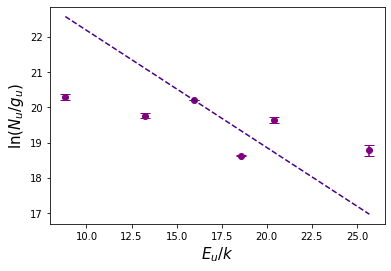

In [623]:
def residual(params, eu, data, eps_data):
    m = -1/params['T']
    b = params['lnNugu_0']
  
    model = m*eu+b

    return (data-model) / eps_data


params = Parameters()
params.add('T', value=10, min=0, max=50)
params.add('lnNugu_0', value=20, min=15, max=30)


out = minimize(residual, params, args=(np.array(emission_line_eup), lnnugu, lnnugu_err))

print(fit_report(out))

T = out.params["T"]
lnNugu_0 = out.params["lnNugu_0"]

Eu_linspace = np.linspace(min(emission_line_eup), max(emission_line_eup), 1000)

def rotdiag_model(Eu, T, lnNugu_0):
    return lnNugu_0 - (1/T)*Eu

plt.scatter(emission_line_eup, lnnugu, c="purple")

plt.errorbar(emission_line_eup, lnnugu, yerr=lnnugu_err, capsize=5, c="purple", fmt="none")

plt.plot(Eu_linspace, rotdiag_model(Eu_linspace, T, lnNugu_0), color="indigo", linestyle="--")
    
plt.ylabel("$\ln(N_u/g_u)$", fontsize=15)
plt.xlabel("$E_u/k$", fontsize=15)
plt.show()